In [1]:
## import standard modules for data handling and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## import model specific modules
import cplex as cp
import slim_python as slim
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

In [2]:
cd ..

C:\Users\danie\Documents\StageDaniel


In [3]:
cd StageDaniel

[WinError 2] Het systeem kan het opgegeven bestand niet vinden: 'StageDaniel'
C:\Users\danie\Documents\StageDaniel


In [9]:
# haberman and breastcancer gives large slim values
# mushroom and bankruptcy, spambase gives large ebm values 
# mushroom creates high sparsity for all models except EBM

dataset = 'adult'
def load_models(name):
    with open('results/models/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
models = load_models(dataset+'_models')
data = load_models(dataset+'_data')

In [21]:
print(models[0][1]['string_model'])

+-------------------------------+-------------------+-----------+
| PREDICT O IF SCORE >= -1      |                   |           |
| ============================= | ================= | ========= |
| Married                       |          2 points |   + ..... |
| AnyCapitalGains               |          2 points |   + ..... |
| Age_22_to_29                  |         -2 points |   + ..... |
| HSDiploma                     |         -2 points |   + ..... |
| WorkHrsPerWeek_lt_40          |         -2 points |   + ..... |
| NoHS                          |         -4 points |   + ..... |
| ============================= | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 6   |             SCORE |   = ..... |
+-------------------------------+-------------------+-----------+


In [5]:
from sklearn import metrics

def extract_results(results, X):
    # Extract specific models from the results

    slim_results = results[0][1]

    rho = slim_results['rho']
    slim_predictions = pred_slim(X,rho)

    ebm = results[1]

    XGboost = results[2]
    explainer = shap.TreeExplainer(XGboost)
    shap_values = explainer.shap_values(X)

    logit = results[3]
    
    return rho, slim_predictions, ebm, explainer, shap_values, logit

## Simple function for getting predictions for a SLIM scoring system
def pred_slim(X, rho):
    return (X.dot(rho[1:])+rho[0]>=0)*1

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def scale_sigmoid(x):
    x_max = np.maximum(x.max(), np.abs(x.min()))
    x = x/(x_max/5)
    return 1/(1 + np.exp(-x))

def force_plot(explanations, model, X, pred_idx=0, link='identity'):
    return shap.force_plot(explanations.loc[model][0], explanations.loc[model][1:-1].values, X.iloc[pred_idx,:], link=link)

def auc(y, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    return metrics.auc(fpr, tpr)

In [6]:
def performance_measures(data, models):
    train_aucs = []
    test_aucs = []
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    slim_results = models[0][1]
    rho = slim_results['rho']
    train_pred = scale_sigmoid(X_train.dot(rho[1:])+rho[0])
    test_pred = sigmoid(X_test.dot(rho[1:])+rho[0])
    train_aucs.append(auc(y_train,train_pred))
    test_aucs.append(auc(y_test,test_pred))
    
    ebm = models[1]
    train_pred = ebm.predict_proba(X_train)
    test_pred = ebm.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))
    
    XGBoost = models[2]
    train_pred = XGBoost.predict_proba(X_train)
    test_pred = XGBoost.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))
    
    logit = models[3]
    train_pred = logit.predict_proba(X_train)
    test_pred = logit.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))

    return pd.DataFrame([train_aucs, test_aucs], ['train', 'test'], ['slim', 'ebm', 'shap', 'logit'])
 
    
    
# performance_measures(data, models)


In [8]:
names = ['bankruptcy','haberman', 'breastcancer', 'mammo', 'spambase', 'mushroom', 'adult']
performances = []

for dataname in names:
    models = load_models(dataname+'_models_3600')
    data = load_models(dataname+'_data_3600')
    performance = performance_measures(data, models)
    performances.append(performance)
performances[-1]

,slim,ebm,shap,logit
train,0.853272,0.891617,0.905032,0.891815
test,0.851983,0.888937,0.893649,0.889084


In [115]:
# corrs_df = pd.concat(corrs, keys = names)
performance_df = pd.concat(performances, keys= names)
performance_df.index.names = ['dataset', 'validation']
performance_df.reset_index()

,dataset,validation,slim,ebm,shap,logit
0,bankruptcy,train,0.993268,1.000000,1.000000,1.000000
1,bankruptcy,test,0.993432,1.000000,1.000000,1.000000
2,haberman,train,0.727394,0.828647,0.940302,0.742876
3,haberman,test,0.604324,0.654054,0.603784,0.634595
4,breastcancer,train,0.992634,0.999526,0.999837,0.996102
5,breastcancer,test,0.992989,0.995172,0.995632,0.995172
6,mammo,train,0.852860,0.857497,0.873702,0.856773
7,mammo,test,0.851398,0.858925,0.850430,0.862957
8,spambase,train,0.963674,0.990104,0.999495,0.977906
9,spambase,test,0.957164,0.968050,0.989047,0.968251


In [160]:
stack = performance_df.stack()
stack.index.names = ['dataset', 'validation', 'model']
pivot = pd.pivot_table(pd.DataFrame(stack), index='dataset', columns = ['validation', 'model'])
print(pivot.round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{0} \\
validation & \multicolumn{4}{l}{test} & \multicolumn{4}{l}{train} \\
model &    ebm &  logit &   shap &   slim &    ebm &  logit &   shap &   slim \\
dataset      &        &        &        &        &        &        &        &        \\
\midrule
bankruptcy   &  1.000 &  1.000 &  1.000 &  0.993 &  1.000 &  1.000 &  1.000 &  0.993 \\
haberman     &  0.654 &  0.635 &  0.604 &  0.604 &  0.829 &  0.743 &  0.940 &  0.727 \\
breastcancer &  0.995 &  0.995 &  0.996 &  0.993 &  1.000 &  0.996 &  1.000 &  0.993 \\
mammo        &  0.859 &  0.863 &  0.850 &  0.851 &  0.857 &  0.857 &  0.874 &  0.853 \\
spambase     &  0.968 &  0.968 &  0.989 &  0.957 &  0.990 &  0.978 &  0.999 &  0.964 \\
mushroom     &  1.000 &  1.000 &  1.000 &  1.000 &  1.000 &  1.000 &  1.000 &  1.000 \\
adult        &  0.889 &  0.889 &  0.894 &  0.852 &  0.892 &  0.892 &  0.905 &  0.853 \\
\bottomrule
\end{tabular}



In [191]:
# pivot.columns = pivot.columns.droplevel(0)
# pivot.columns.sortlevel(0)
pivot.columns.sortlevel(1, ('train','slim'))

(MultiIndex([( 'test',   'ebm'),
             ('train',   'ebm'),
             ( 'test', 'logit'),
             ('train', 'logit'),
             ( 'test',  'shap'),
             ('train',  'shap'),
             ( 'test',  'slim'),
             ('train',  'slim')],
            names=['validation', 'model']),
 array([0, 4, 1, 5, 2, 6, 3, 7], dtype=int64))

(array([2958.,    0.,    0.,  406.,    0.,    0., 1347.,    0.,    0.,
        1788.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

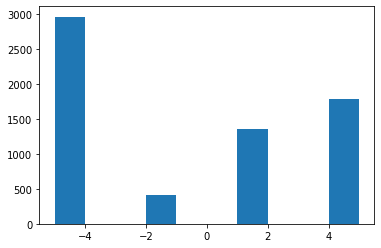

In [14]:
rho = models[0][1]['rho']
x = X_train.dot(rho[1:])+rho[0]
x_max = np.maximum(x.max(), np.abs(x.min()))
x = x/(x_max/5)
1/(1 + np.exp(-x))
# np.abs(x.min()
plt.hist(x.values)